Simulating analytical model of a 1-dof training rig

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
g = 9.81

# Geometry (m)
L_b = 0.6
L_c = 0.4
ell = L_b + L_c

# Masses (kg)
m_a = 2.0
m_b = 1.5
m_c = 1.0

# Rod COM location from pivot A
x_O = (L_b - L_c) / 2.0

# Moment of Inertia matrices about inertial frame N
I_a = np.diag([m_a*(L_b**3 + L_c**3)/(3*ell),m_a*(L_b**3 + L_c**3)/(3*ell),0])

# Body inertia about inertial frame N
I_b = np.diag([m_b*L_b**2,m_b*L_b**2,0])

# Compensator inertia about inertial frame N
I_c = np.diag([m_c*L_b**2,m_c*L_b**2,0])

# Total inertia about inertial frame N
I_tot = I_a + I_b + I_c

M_eff = m_a * x_O + m_b * L_b - m_c * 

# Position vectors in frame A
r_a_A = np.array([0, 0, x_O])

r_b_A = np.array([0, 0, L_b])

r_c_A = np.array([0, 0, -L_c])

# Rotation matrix C
def C_NA(q):
    return np.array([
        [np.cos(q[0]), -np.sin(q[0]), 0],
        [np.sin(q[0]),  np.cos(q[0]), 0],
        [0,             0,            1]
    ])

In [ ]:
def tau_ext(t):
    return 2.0 * np.sin(2.0 * t)

def omega(q, qdot):
    return np.array([0, 0, qdot[0]])

In [ ]:
def kinetic_energy(q, qdot):

    C = C_NA(q)
    w = omega_N(qdot)

    # Transform positions to N
    r_OA_N = C @ r_OA_A
    r_CA_N = C @ r_CA_A
    r_BA_N = C @ r_BA_A

    # Velocities
    v_OA = np.cross(w, r_OA_N)
    v_CA = np.cross(w, r_CA_N)
    v_BA = np.cross(w, r_BA_N)

    # Translational KE
    T_trans = (
        0.5*M_a*v_OA@v_OA +
        0.5*M_c*v_CA@v_CA +
        0.5*M_b*v_BA@v_BA
    )

    # Rotational KE
    T_rot = (
        0.5*w@I_a_COM@w +
        0.5*w@I_b_COM@w +
        0.5*w@I_c_COM@w
    )

    return T_trans + T_rot


def potential_energy(q):

    C = C_NA(q)

    g_vec = np.array([-g, 0, 0])

    P = (
        M_a * g_vec @ (C @ r_OA_A) +
        M_c * g_vec @ (C @ r_CA_A) +
        M_b * g_vec @ (C @ r_BA_A)
    )

    return P

In [ ]:
def qdd(q, qdot, t):

    # Compute ∂P/∂q numerically (from exact P expression)
    eps = 1e-6
    dP_dq = (potential_energy(q+eps) - potential_energy(q-eps)) / (2*eps)

    # Compute ∂²K/∂qdot² numerically
    eps2 = 1e-6
    d2K = (
        kinetic_energy(q, qdot+eps2)
        - 2*kinetic_energy(q, qdot)
        + kinetic_energy(q, qdot-eps2)
    ) / eps2**2

    Q = 2.0*np.sin(2*t)  # generalized torque τ(t)

    return (Q - dP_dq) / d2K

In [ ]:
def rk4_step(q, qdot, t, dt):

    def f(state, time):
        return np.array([
            state[1],
            qdd(state[0], state[1], time)
        ])

    y = np.array([q, qdot])

    k1 = f(y, t)
    k2 = f(y + dt*k1/2, t+dt/2)
    k3 = f(y + dt*k2/2, t+dt/2)
    k4 = f(y + dt*k3, t+dt)

    y_next = y + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    return y_next[0], y_next[1]

In [14]:
t0 = 0.0
tf = 15.0
dt = 0.002

time = np.arange(t0, tf, dt)
N = len(time)

state = np.zeros((N, 2))

# Initial conditions
state[0,0] = 0.2
state[0,1] = 0.0

for i in range(N-1):
    state[i+1] = rk4_step(dynamics, time[i], state[i], dt)

q = state[:,0]
qdot = state[:,1]
tau_vals = np.array([tau_ext(t) for t in time])

In [15]:
K = 0.5 * I_tot * qdot**2
V = M_eff * g * np.sin(q)
E = K + V

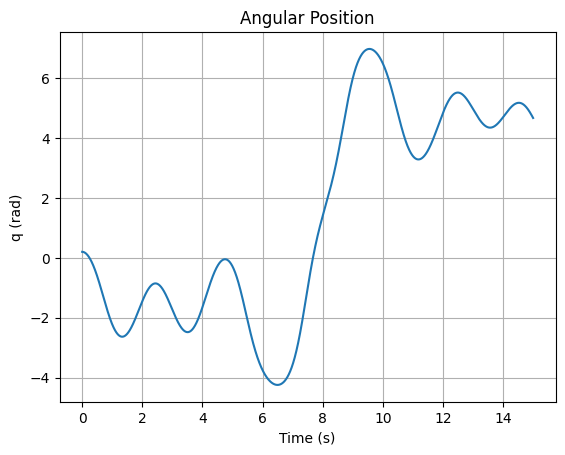

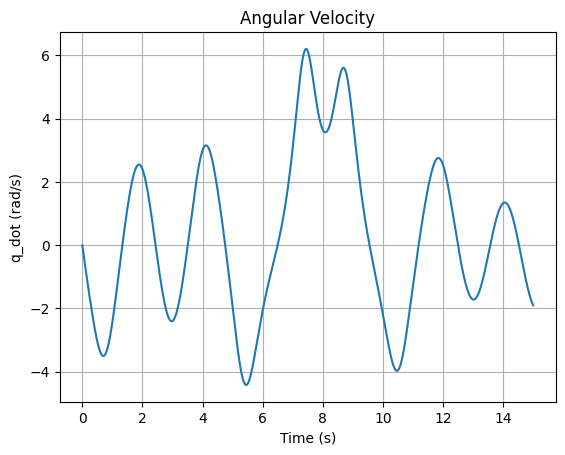

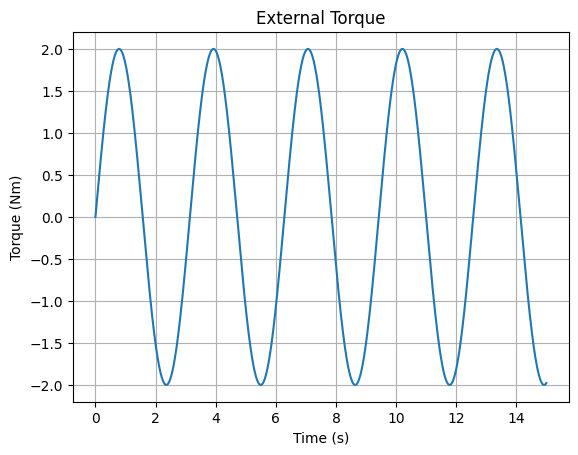

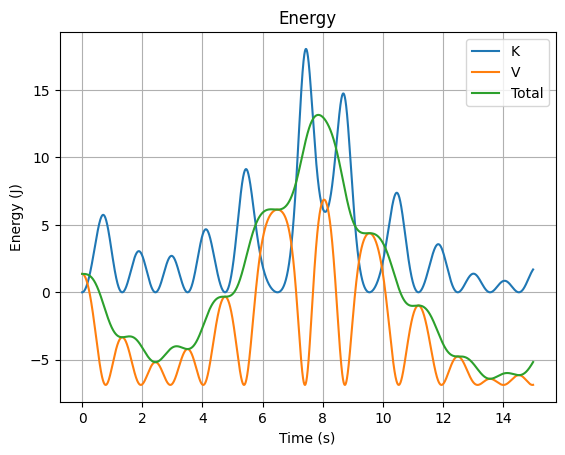

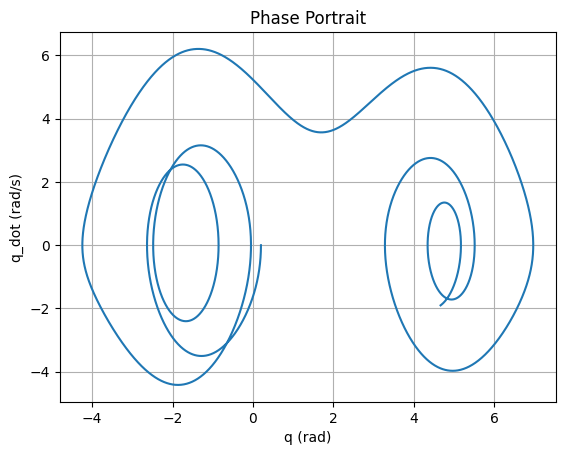

In [16]:
plt.figure()
plt.plot(time, q)
plt.xlabel("Time (s)")
plt.ylabel("q (rad)")
plt.title("Angular Position")
plt.grid()

plt.figure()
plt.plot(time, qdot)
plt.xlabel("Time (s)")
plt.ylabel("q_dot (rad/s)")
plt.title("Angular Velocity")
plt.grid()

plt.figure()
plt.plot(time, tau_vals)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.title("External Torque")
plt.grid()

plt.figure()
plt.plot(time, K, label="K")
plt.plot(time, V, label="V")
plt.plot(time, E, label="Total")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.title("Energy")
plt.legend()
plt.grid()

plt.figure()
plt.plot(q, qdot)
plt.xlabel("q (rad)")
plt.ylabel("q_dot (rad/s)")
plt.title("Phase Portrait")
plt.grid()

plt.show()

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-ell-0.2, ell+0.2)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-ell-0.2, ell+0.2)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect((1.0, 0.5, 1.0))
ax.view_init(elev=22, azim=-60)
ax.set_title("1-DOF Training Rig (3D View)")

line, = ax.plot([], [], [], lw=2)
body_point, = ax.plot([], [], [], 'o', markersize=8)
comp_point, = ax.plot([], [], [], 'o', markersize=8)

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    body_point.set_data([], [])
    body_point.set_3d_properties([])
    comp_point.set_data([], [])
    comp_point.set_3d_properties([])
    return line, body_point, comp_point

def update(frame):
    angle = q[frame]

    x_body = L_b * np.cos(angle)
    z_body = L_b * np.sin(angle)

    x_comp = -L_c * np.cos(angle)
    z_comp = -L_c * np.sin(angle)

    y_body = 0.0
    y_comp = 0.0

    line.set_data([x_comp, x_body], [y_comp, y_body])
    line.set_3d_properties([z_comp, z_body])
    body_point.set_data([x_body], [y_body])
    body_point.set_3d_properties([z_body])
    comp_point.set_data([x_comp], [y_comp])
    comp_point.set_3d_properties([z_comp])

    return line, body_point, comp_point

ani = FuncAnimation(
    fig,
    update,
    frames=range(0, N, 20),
    init_func=init,
    blit=False
)

plt.close(fig)
HTML(ani.to_jshtml())